# **[1] Importing Libraries and Reading Data**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import nltk
import spacy
import warnings
import re
import random
import joblib
import torch
from torch.utils.data import Dataset
from sklearn.metrics import confusion_matrix , accuracy_score, classification_report
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
warnings.filterwarnings('ignore')

In [ ]:
train_data = pd.read_csv('/content/training.csv')

test_data = pd.read_csv('/content/test.csv')

val_data = pd.read_csv('/content/validation.csv')

# **[2] Data Overview**

In [ ]:
labels_dict = {0:'sadness', 1:'joy', 2:'love', 3:'anger', 4:'fear', 5:'surprise'}
train_data['description'] = train_data['label'].map(labels_dict )

In [ ]:
train_data.head()

,text,label,description
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [ ]:
val_data.head()

,text,label
0,im feeling quite sad and sorry for myself but ...,0
1,i feel like i am still looking at a blank canv...,0
2,i feel like a faithful servant,2
3,i am just feeling cranky and blue,3
4,i can have for a treat or if i am feeling festive,1


In [ ]:
test_data.head()

,text,label
0,im feeling rather rotten so im not very ambiti...,0
1,im updating my blog because i feel shitty,0
2,i never make her separate from me because i do...,0
3,i left with my bouquet of red and yellow tulip...,1
4,i was feeling a little vain when i did this one,0


In [ ]:
print('Dataset information:')
print(f'Training data: {train_data.shape}')
print(f'Validation data: {val_data.shape}')
print(f'Test data: {test_data.shape}')

Dataset information:
Training data: (16000, 3)
Validation data: (2000, 2)
Test data: (2000, 2)


* **`16,000`** training examples.
* **`2,000`** example for validation and test.




Distribution of the labels in the training set

In [ ]:
train_data['description'].value_counts()

description
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

* **Suprise** class is rarely exisiting in the training data.

In [ ]:
fig = px.pie(names=train_data['description'].value_counts().index,values=train_data['description'].value_counts().values,title='Distribution for each label',labels=train_data['description'].value_counts().index)
fig.update_traces(marker=dict(colors=px.colors.qualitative.Pastel))
fig.show()

* Most occuring class is **Joy** ,then **Sadness**

In [ ]:
train_data['label'].nunique()

6

# **[3] Text Preprocessing**

In [ ]:
sampled_df = train_data.groupby('description').apply(lambda x: x.sample(1))
sampled_df

,,text,label,description
description,,,,
anger,15882,i mean that it feels to me that she feels that...,3,anger
fear,9175,i feel pretty terrified immature and not ready,4,fear
joy,3173,i hope she s feeling ok,1,joy
love,8329,i stand you come across as a complete stranger...,2,love
sadness,2404,i wasnt supposed to be with n to just let it h...,0,sadness
surprise,408,i honestly am not sure how i feel stunned,5,surprise


In [ ]:
max_length = train_data['text'].str.split().str.len().max()
min_length = train_data['text'].str.split().str.len().min()

print("Maximum entry length:", max_length)
print("Minimum entry length:", min_length)

Maximum entry length: 66
Minimum entry length: 2


In [ ]:
train_data['text_length']=train_data['text'].apply(lambda x : len(x.split()))

In [ ]:
train_data.iloc[train_data['text_length'].idxmin()]

text           earth crake
label                    4
description           fear
text_length              2
Name: 4150, dtype: object

In [ ]:
train_data[(train_data['text_length']>=2) & (train_data['text_length']<=3)]

,text,label,description,text_length
237,im feeling cranky,3,anger,3
303,fear of thief,4,fear,3
731,im feeling fine,1,joy,3
888,i feel bothered,3,anger,3
951,id feel better,1,joy,3
1357,i feel lovely,2,love,3
1375,i feel festive,1,joy,3
1526,i feel fabulous,1,joy,3
2799,im feeling boring,0,sadness,3
2981,i feeling boring,0,sadness,3


In [ ]:
nlp = spacy.load("en_core_web_sm")

## **Lemmetization**

Applying lemmatization to our texts as an initial step in the preprocessing stage helps ensure that words are reduced to their base form, facilitating more accurate analysis downstream.

To maintain the original meaning in texts that contain words like **"didn't", "wasn't"**, etc., often found in expressions of sadness, we initialized a list with these negative contractions.

In [ ]:
stop_words = spacy.lang.en.stop_words.STOP_WORDS

negative_words = ["not", "n't","nt"]

Method that lemmatize texts in the data where it checks if the text is not within the negative extensions or stop words if so,it apply lemmatiztion for the words.

In [ ]:
def lemmatize_text(text):
    doc = nlp(text)

    lemmatized_tokens = []
    for token in doc:
        # Check if the token is a stop word or a negative word
        if token.text.lower() in stop_words or token.text.lower() in negative_words:
            # If it is a stop word or negative word, append the token as it is to the list
            lemmatized_tokens.append(token.text)
        else:
            # If it is not a stop word or negative word, append the lemma of the token to the list
            lemmatized_tokens.append(token.lemma_)
    # Return the lemmatized text as a string
    return ' '.join(lemmatized_tokens)

Checking for the entries that contain negative extensions within the train data.

In [ ]:
pattern = '|'.join(negative_words)
train_data[train_data['text'].str.contains(pattern, case=False)]

,text,label,description,text_length
0,i didnt feel humiliated,0,sadness,4
5,ive been feeling a little burdened lately wasn...,0,sadness,12
6,ive been taking or milligrams or times recomme...,5,surprise,23
9,i feel romantic too,2,love,4
11,i do feel that running is a divine experience ...,1,joy,21
...,...,...,...,...
15990,i feel really glad that i dont look like the c...,1,joy,20
15991,i have wanted to perhaps convey my feelings of...,0,sadness,28
15992,i moved away he said something that made me fe...,3,anger,19
15998,i feel like this was such a rude comment and i...,3,anger,14


* 7234 row contains texts that have negative meaning containing words with **[not,n't]**

In [ ]:
# lemmatized_text = lemmatize_text(text)
# lemmatized_text

Applying the lemmatization to the texts within our train , val , test datasets.

In [ ]:
train_data['lemmatized_text'] = train_data['text'].apply(lemmatize_text)
val_data['lemmatized_text'] = val_data['text'].apply(lemmatize_text)
test_data['lemmatized_text'] = test_data['text'].apply(lemmatize_text)

Checking for random entries before and after lemmatization in train data

In [ ]:
print("Texts before Lemmitization \n",train_data.loc[0:5, 'text'])
print("\n")
print("Texts after Lemmitization \n",train_data.loc[0:5, 'lemmatized_text'])

Texts before Lemmitization 
 0                              i didnt feel humiliated
1    i can go from feeling so hopeless to so damned...
2     im grabbing a minute to post i feel greedy wrong
3    i am ever feeling nostalgic about the fireplac...
4                                 i am feeling grouchy
5    ive been feeling a little burdened lately wasn...
Name: text, dtype: object


Texts after Lemmitization 
 0                              i did nt feel humiliate
1    i can go from feel so hopeless to so damned ho...
2        i m grab a minute to post i feel greedy wrong
3    i am ever feel nostalgic about the fireplace i...
4                                    i am feel grouchy
5    i ve been feel a little burden lately was nt s...
Name: lemmatized_text, dtype: object


In [ ]:
NUM_LABELS= 6
id2label={0:'sadness', 1:'joy', 2:'love', 3:'anger', 4:'fear', 5:'surprise'}

label2id= {'sadness':0, 'joy':1, 'love':2,'anger':3, 'fear':4, 'surprise':5}


In [ ]:
label2id

{'sadness': 0, 'joy': 1, 'love': 2, 'anger': 3, 'fear': 4, 'surprise': 5}

In [ ]:
id2label

{0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

# **[4] Modeling**

Exploring text transformer models enables us to leverage their predictive power, allowing for more accurate and insightful predictions on textual data.

In [ ]:
from transformers import TrainingArguments, Trainer

In [ ]:
class DataLoader(Dataset):
    """
    Custom Dataset class for handling tokenized text data and corresponding labels.
    Inherits from torch.utils.data.Dataset.
    """
    def __init__(self, encodings, labels):
        """
        Initializes the DataLoader class with encodings and labels.

        Args:
            encodings (dict): A dictionary containing tokenized input text data
                              (e.g., 'input_ids', 'token_type_ids', 'attention_mask').
            labels (list): A list of integer labels for the input text data.
        """
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        """
        Returns a dictionary containing tokenized data and the corresponding label for a given index.

        Args:
            idx (int): The index of the data item to retrieve.

        Returns:
            item (dict): A dictionary containing the tokenized data and the corresponding label.
        """
        # Retrieve tokenized data for the given index
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Add the label for the given index to the item dictionary
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        """
        Returns the number of data items in the dataset.

        Returns:
            (int): The number of data items in the dataset.
        """
        return len(self.labels)


In [ ]:
def compute_metrics(pred):
    """
    Computes accuracy, F1, precision, and recall for a given set of predictions.

    Args:
        pred (obj): An object containing label_ids and predictions attributes.
            - label_ids (array-like): A 1D array of true class labels.
            - predictions (array-like): A 2D array where each row represents
              an observation, and each column represents the probability of
              that observation belonging to a certain class.

    Returns:
        dict: A dictionary containing the following metrics:
            - Accuracy (float): The proportion of correctly classified instances.
            - F1 (float): The macro F1 score, which is the harmonic mean of precision
              and recall. Macro averaging calculates the metric independently for
              each class and then takes the average.
            - Precision (float): The macro precision, which is the number of true
              positives divided by the sum of true positives and false positives.
            - Recall (float): The macro recall, which is the number of true positives
              divided by the sum of true positives and false negatives.
    """
    # Extract true labels from the input object
    labels = pred.label_ids

    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)

    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')

    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)

    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

In [ ]:
train_texts = list(train_data['lemmatized_text'])
val_texts = list(val_data['lemmatized_text'])
test_texts = list(test_data['lemmatized_text'])

train_labels = list(train_data['label'])
val_labels = list(val_data['label'])
test_labels = list(test_data['label'])

### **4.1 Roberta Transformer**

Initially experimenting with the Roberta Transformer model to assess its effectiveness and potential in accurately predicting and classifying the textual data pertinent to our task.

In [ ]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW

Initially, setting up the Roberta Tokenizer to tokenize the available texts ensures thorough text tokenization and preprocessing to facilitate optimal model performance.

In [ ]:
roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [ ]:
NUM_LABELS = 6

roberta_model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=NUM_LABELS, id2label=id2label , label2id=label2id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
roberta_model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

Tokenizing our training, testing, and validation datasets with the Roberta tokenizer will streamline our data preprocessing, ensuring compatibility with the model's requirements.

In [ ]:
train_encodings = roberta_tokenizer(train_texts, truncation=True, padding=True)
val_encodings  = roberta_tokenizer(val_texts, truncation=True, padding=True)
test_encodings = roberta_tokenizer(test_texts, truncation=True, padding=True)

In [ ]:
train_dataloader = DataLoader(train_encodings, train_labels)

val_dataloader = DataLoader(val_encodings, val_labels)

test_dataset = DataLoader(test_encodings, test_labels)

In [ ]:
# pip install accelerate -U

In [ ]:
training_args = TrainingArguments(
    # The output directory where the model predictions and checkpoints will be written
    output_dir='RobertaModel',
    do_train=True,
    do_eval=True,
    #  The number of epochs, defaults to 3.0
    num_train_epochs=5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    # Number of steps used for a linear warmup
    warmup_steps=100,
    weight_decay=0.01,
    logging_strategy='steps',
   # TensorBoard log directory
    logging_dir='./multi-class-logs',
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    load_best_model_at_end=True
)

In [ ]:
roberta_trainer = Trainer(
    # the pre-trained model that will be fine-tuned
    model=roberta_model,
     # training arguments that we defined above
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=val_dataloader,
    compute_metrics= compute_metrics
)

In [ ]:
roberta_trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,0.106300,0.156825,0.935000,0.907310,0.926845,0.892340


KeyboardInterrupt: 

In [ ]:
roberta_trainer.save_model('Roberta2-emotion-detection-model')

In [ ]:
roberta_tokenizer.save_pretrained('Roberta2-emotion-detection-tokenizer')

('Roberta2-emotion-detection-tokenizer/tokenizer_config.json',
 'Roberta2-emotion-detection-tokenizer/special_tokens_map.json',
 'Roberta2-emotion-detection-tokenizer/vocab.json',
 'Roberta2-emotion-detection-tokenizer/merges.txt',
 'Roberta2-emotion-detection-tokenizer/added_tokens.json')

In [ ]:
def predict_roberta(text):
    # Tokenize the input text and move tensors to the GPU if available
    inputs = roberta_tokenizer(text ,return_tensors="pt").to("cuda")

    # Get model output (logits)
    outputs = roberta_model(**inputs)

    probs = outputs[0].softmax(1)

    # Get the index of the class with the highest probability
    pred_label_idx = probs.argmax()

    # Now map the predicted class index to the actual class label
    pred_label = roberta_model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label

In [ ]:
predict_roberta('I feel happy')[2]

'joy'

In [ ]:
roberta_model.eval()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [ ]:
evaluate = [roberta_trainer.evaluate(eval_dataset=test_data) for test_data in [test_dataset]]

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,0.106300,0.156825,0.935000,0.907310,0.926845,0.892340
85,0.106300,0.184462,0.925500,0.882454,0.893768,0.873830


In [ ]:
pd.DataFrame(evaluate, index=["test"]).iloc[:,:5]

,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
test,0.184462,0.9255,0.882454,0.893768,0.87383


In [ ]:
predictions = roberta_trainer.predict(test_dataset)

logits = predictions.predictions
logits_tensor = torch.tensor(logits)

# Convert logits tensor to predicted labels
predicted_labels = torch.argmax(logits_tensor, dim=1).tolist()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,0.106300,0.156825,0.935000,0.907310,0.926845,0.892340
85,0.106300,0.184462,0.925500,0.882454,0.893768,0.873830


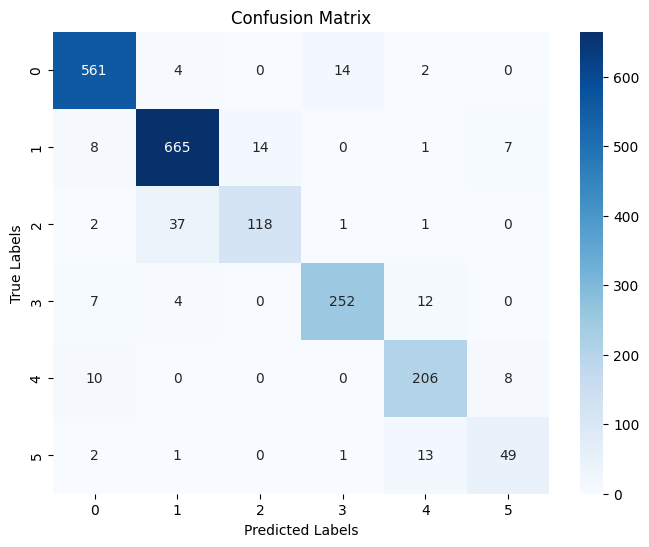

In [ ]:
conf_matrix = confusion_matrix(test_labels, predicted_labels)
classes=[0,1,2,3,4,5]
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print("Test Accuracy : ", accuracy_score(test_labels,predicted_labels))

Test Accuracy :  0.9255


In [ ]:
print("Classification Report \n: ", classification_report(test_labels,predicted_labels))

Classification Report 
:                precision    recall  f1-score   support

           0       0.95      0.97      0.96       581
           1       0.94      0.96      0.95       695
           2       0.89      0.74      0.81       159
           3       0.94      0.92      0.93       275
           4       0.88      0.92      0.90       224
           5       0.77      0.74      0.75        66

    accuracy                           0.93      2000
   macro avg       0.89      0.87      0.88      2000
weighted avg       0.93      0.93      0.92      2000



In [ ]:
roberta_nlp= pipeline("sentiment-analysis", model=roberta_model, tokenizer=roberta_tokenizer)

In [ ]:
roberta_nlp("i feel angry")[2]

IndexError: list index out of range

### **4.2 Bert Transformer**

Exploring the capabilities of BERT for our task is a journey towards unlocking higher accuracy and performance.

In [ ]:
from transformers import pipeline, BertForSequenceClassification, BertTokenizerFast

Initiate our BERT tokenizer, paving the way for efficient and effective tokenization in our task.

In [ ]:
Bert_tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased",max_length=512)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Initializing the BERT sequence classifier with the appropriate number of classes, customizing it to fit the specific demands of our problem.

In [ ]:
bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=NUM_LABELS, id2label=id2label , label2id=label2id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

Tokenizing our training, testing, and validation datasets with the BERT tokenizer will streamline our data preprocessing, ensuring compatibility with the model's requirements.

In [ ]:
train_encodings = Bert_tokenizer(train_texts, truncation=True, padding=True)
val_encodings  = Bert_tokenizer(val_texts, truncation=True, padding=True)
test_encodings = Bert_tokenizer(test_texts, truncation=True, padding=True)

In [ ]:
train_dataloader = DataLoader(train_encodings, train_labels)

val_dataloader = DataLoader(val_encodings, val_labels)

test_dataset = DataLoader(test_encodings, test_labels)

Defining our trainer configurations empowers us to tailor the training process to our specific needs, ensuring optimal performance and efficiency.

In [ ]:
training_args = TrainingArguments(
    # The output directory where the model predictions and checkpoints will be written
    output_dir='BertModel',
    do_train=True,
    do_eval=True,
    #  The number of epochs, defaults to 3.0
    num_train_epochs=5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    # Number of steps used for a linear warmup
    warmup_steps=100,
    weight_decay=0.01,
    logging_strategy='steps',
   # TensorBoard log directory
    logging_dir='./multi-class-logs',
    logging_steps=100,
    evaluation_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    load_best_model_at_end=True
)

In [ ]:
bert_trainer = Trainer(
    # the pre-trained model that will be fine-tuned
    model=bert_model,
     # training arguments that we defined above
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=val_dataloader,
    compute_metrics= compute_metrics
)

Training our BERT model will refine its understanding of our dataset, enhancing its ability to accurately predict outcomes for our task.

In [ ]:
bert_trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
100,1.467200,0.901623,0.696000,0.468821,0.603746,0.481719
200,0.562900,0.363074,0.890500,0.861389,0.856665,0.869590
300,0.334300,0.301290,0.902000,0.872799,0.876521,0.870053
400,0.279100,0.233577,0.917500,0.893599,0.892319,0.897421
500,0.237200,0.213755,0.914500,0.892309,0.881494,0.909802
600,0.164500,0.207363,0.928000,0.900549,0.923984,0.884317
700,0.166700,0.179744,0.933000,0.907241,0.924157,0.894022
800,0.156000,0.205913,0.933000,0.910139,0.931886,0.895188
900,0.173100,0.187636,0.919000,0.892584,0.905165,0.887153
1000,0.150400,0.158761,0.930000,0.903451,0.917753,0.895328


TrainOutput(global_step=2500, training_loss=0.19404649772644042, metrics={'train_runtime': 1442.8988, 'train_samples_per_second': 55.444, 'train_steps_per_second': 1.733, 'total_flos': 3576794362560000.0, 'train_loss': 0.19404649772644042, 'epoch': 5.0})

In [ ]:
bert_trainer.save_model('Bert-emotion-detection-model')
Bert_tokenizer.save_pretrained('Bert-emotion-detection-tokenizer')

('Bert-emotion-detection-tokenizer/tokenizer_config.json',
 'Bert-emotion-detection-tokenizer/special_tokens_map.json',
 'Bert-emotion-detection-tokenizer/vocab.txt',
 'Bert-emotion-detection-tokenizer/added_tokens.json',
 'Bert-emotion-detection-tokenizer/tokenizer.json')

In [ ]:
bert_model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
def predict_bert(text):
    # Tokenize the input text and move tensors to the GPU if available
    inputs = Bert_tokenizer(text ,return_tensors="pt").to("cuda")

    # Get model output (logits)
    outputs = bert_model(**inputs)

    probs = outputs[0].softmax(1)
    # Get the index of the class with the highest probability
    pred_label_idx = probs.argmax()

    # Now map the predicted class index to the actual class label
    pred_label = bert_model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label

In [ ]:
predict_bert('I feel happy')[2]

'joy'

In [ ]:
test_evaluate=[bert_trainer.evaluate(eval_dataset=test_data) for test_data in [test_dataset]]

In [ ]:
test_evaluate

[{'eval_loss': 0.1856721192598343,
  'eval_Accuracy': 0.9205,
  'eval_F1': 0.8713953110733531,
  'eval_Precision': 0.8872805361946425,
  'eval_Recall': 0.8670141035505189,
  'eval_runtime': 8.8571,
  'eval_samples_per_second': 225.807,
  'eval_steps_per_second': 7.113,
  'epoch': 5.0}]

In [ ]:
predictions = bert_trainer.predict(test_dataset)

logits = predictions.predictions
logits_tensor = torch.tensor(logits)

predicted_labels = torch.argmax(logits_tensor, dim=1).tolist()

In [ ]:
true_labels_np = np.array(test_labels)
predicted_labels_np = np.array(predicted_labels)

In [ ]:
from sklearn.metrics import confusion_matrix , accuracy_score, classification_report

print("Test Accuracy : ", accuracy_score(true_labels_np,predicted_labels_np))

Test Accuracy :  0.9205


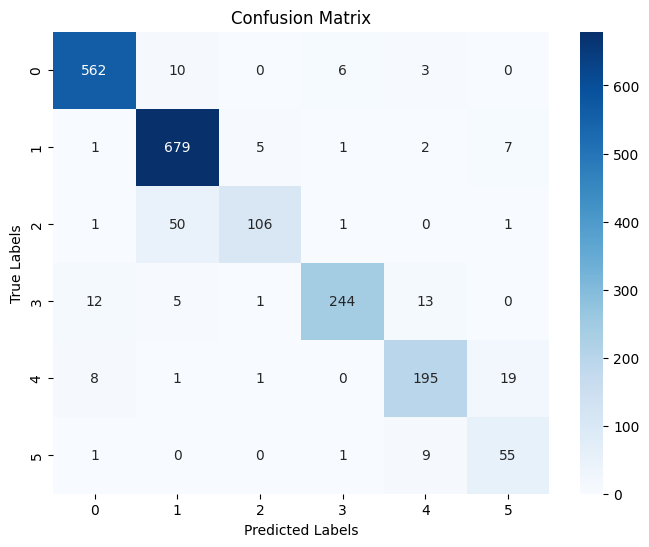

In [ ]:
conf_matrix = confusion_matrix(true_labels_np, predicted_labels_np)
classes=[0,1,2,3,4,5]
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print("Classification Report : ", classification_report(true_labels_np,predicted_labels_np))

Classification Report :                precision    recall  f1-score   support

           0       0.96      0.97      0.96       581
           1       0.91      0.98      0.94       695
           2       0.94      0.67      0.78       159
           3       0.96      0.89      0.92       275
           4       0.88      0.87      0.87       224
           5       0.67      0.83      0.74        66

    accuracy                           0.92      2000
   macro avg       0.89      0.87      0.87      2000
weighted avg       0.92      0.92      0.92      2000



In [ ]:
bert_nlp= pipeline("sentiment-analysis", model=bert_model, tokenizer=Bert_tokenizer)

In [ ]:
bert_nlp("i feel scared")[0]

{'label': 'fear', 'score': 0.9980788230895996}

# **Credits :**

> <font size='4'>**Team Members :**</font>

- [Mohamed Samy](https://www.linkedin.com/in/mohamed-samy10/)
- [Yomna Mohammed](https://www.linkedin.com/in/yomna-muhammed-b964a6270)




